<a href="https://colab.research.google.com/github/divyanshgupt/Unreliable-Transmission/blob/main/Superspike_Multilayer_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
#@title Dependencies
import numpy as np
from matplotlib import pyplot as plt

import torch

from tqdm import tqdm

In [16]:
dtype = torch.float
device = torch.device('cpu')

#device = torch.device('cuda:0')


In [17]:
nb_inputs = 100
nb_hidden = 4
nb_outputs = 1

In [18]:
args = {'thres': -50,
        'u_rest': -60,
        'tau_mem': 1e-2,
        'tau_syn': 5e-3,
        'tau_ref': 5e-3,
        't_rise': 5e-3, # the pre-synaptic double exponential kernel rise time
        't_decay': 1e-2, # the pre-synaptic double exponential kernel decay time
        'timestep_size': 1e-4, # 0.1 msec
        't_rise_alpha': 5e-3, # change this
        't_decay_alpha': 1e-2, # change this 
        'nb_steps': 5000} # 0.5 secs in total

nb_steps = args['nb_steps']
timestep_size = args['timestep_size']

In [19]:
tau_mem = args['tau_mem']
tau_syn = args['tau_syn']
dt = args['timestep_size']

alpha = float(np.exp(-dt/tau_syn))
beta = float(np.exp(-dt/tau_mem))

In [51]:
#@title Helper Functions

# Threshold Spike Function
def spike_fn(x, thres):
  """
  Implements a heaviside function centred at the firing threshold
  """
  x = x - thres
  out = torch.zeros_like(x, device=device, dtype=dtype)
  out[x > 0] = 1
  return out

# Presynaptic Trace
def presynaptic_trace(input_trains, args):
  """
  Evaluates the presynaptic trace (double exponential kernel)
  given the whole input trains
  Inputs:
    input_trains
    args:['timestep_size', 't_rise', 't_decay', 'nb_steps']
  Returns:
    Presynaptic Trace 
  """
  dt = args['timestep_size']
  t_rise = args['t_rise']
  t_decay = args['t_decay']
  nb_timesteps = args['nb_steps']
  nb_trains = len(input_trains)

  trace_1 = torch.zeros((nb_trains, nb_timesteps), device=device, dtype=dtype)
  trace_2 = torch.zeros((nb_trains, nb_timesteps), device=device, dtype=dtype)

  for t in range(nb_timesteps - 1):
    trace_1[:, t+1] = trace_1[:, t] + (-trace_1[:, t]/t_rise + input_trains[:, t])*dt
    trace_2[:, t+1] = trace_2[:, t] + (-trace_2[:, t] + trace_1[:, t])*dt/t_decay

  return trace_2

# Eligibility Trace
def eligibility_trace(hebbian, args):
  """
  Evaluate the hebbian-coincidence based eligibility trace over all timesteps
  for all the given synaptic connections in the hebbian matrix using the 
  double exponential kernel.
  Inputs:
    hebbian - 3-D matrix of shape: (nb_inputs, nb_outputs, nb_steps)
    args: ['timestep_size', 't_rise_alpha', 't_decay_alpha', 'nb_steps']
  Returns:
    Eligibilty trace matrix of shape: (nb_inputs, nb_outputs, nb_steps)
  """
  dt = args['timestep_size']
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  nb_timesteps = args['nb_steps']
  nb_inputs = hebbian.shape[0]
  nb_outputs = hebbian.shape[1]

  trace_1 = torch.zeros((nb_inputs, nb_outputs, nb_timesteps), device=device,
                       dtype=dtype)
  trace_2 = torch.zeros((nb_inputs, nb_outputs, nb_timesteps), device=device,
                        dtype=dtype)
  for t in range(nb_timesteps-1):
    trace_1[:, :, t+1] = trace_1[:, :, t] + (-trace_1[:, :, t]/t_rise + hebbian[:, :, t])*dt
    trace_2[:, :, t+1] = trace_2[:, :, t] + (-trace_2[:, :, t] + trace_1[:, :, t])*dt/t_decay
  
  return trace_2

# Error Signal
def error_signal(output, target, args):
  """
  Evaluates the error signal by running the double exponential 
  kernel on the difference of the output and the target spike trains.
  Inputs:
    output - spike_train, shape: (nb_steps,)
    target - spike_train, shape: (nb_steps,)
    args:['timestep_size', 't_rise_alpha', 't_decay_alpha', 'nb_steps']
  Returns
    Error Signal Trace of shape: (nb_steps,)
  """
  t_rise = args['t_rise_alpha']
  t_decay = args['t_decay_alpha']
  dt = args['timestep_size']
  nb_timesteps = args['nb_steps']

  trace_1 = torch.zeros(nb_timesteps, device=device, dtype=dtype)
  trace_2 = torch.zeros(nb_timesteps, device=device, dtype=dtype)

  difference = target - output
  for t in range(nb_timesteps - 1):
    trace_1[t + 1] = trace_1[t] + (-trace_1[t]/t_rise + difference[t])*dt
    trace_2[t + 1] = trace_2[t] + (-trace_2[t] + trace_1[t])*dt/t_decay

  return trace_2

# Feedback Signal


# Poisson Train Generator
def Poisson_trains(n, lam, timesteps, dt):
  """
  Generates homogeneous poisson trains
  inputs:
    n - number of poisson spike trains 
    lam - 1-D array containing mean value of poisson trains
  Returns
    2-D array of shape (n,timesteps)
  """
  trains = torch.zeros((n, timesteps), device=device, dtype=dtype)
  unif = torch.rand((n, timesteps), device=device, dtype=dtype)
  for i in range(n):
    trains[unif <= lam[i]*dt] = 1

  return trains


In [42]:
#@title Plotting Functions
def plot_single_train(spike_train, nb_steps, timestep_size, idx=0):
  """
  Inputs:
    spike_train: 
    nb_steps:
    timestep_size
  Returns:
    Plots eventplot of spike positions.
  """
  positions = np.arange(0, nb_steps)
 # print(spike_train == 1)
  spike_positions = positions[spike_train == 1]
 # print(spike_positions)
  plt.eventplot(spike_positions, lineoffsets=idx)
  plt.xlim(0, nb_steps)
  #plt.show()

def plot_trains(spike_trains, title='Spike Trains'):
  plt.figure(dpi = 100)
  for i in range(len(spike_trains)):
    plot_single_train(spike_trains[i], nb_steps, timestep_size, idx=i)
  plt.title(title)
  plt.xlabel('Timestep')
  plt.ylabel('Spike Train No.')
  plt.show()


def plot_traces(eligiblity_rec, pre_synaptic_rec, input_trains, idx):
    
  j = idx

  fig, axs = plt.subplots(3, sharex=True, figsize=(15,10), dpi=120)

  axs[0].plot(eligibility_rec[j])
  axs[0].set_title("Eligibility Trace No." + str(j))
 
  positions = np.arange(0, nb_steps)
  spike_positions = positions[input_trains[j] == 1]
  axs[1].eventplot(spike_positions)
  axs[1].set_title("Corresponding Input Train No." + str(j))
  axs[1].set_xlim([0, nb_steps])

  axs[2].plot(pre_trace_rec[j])
  axs[2].set_title("Presynaptic Trace No." + str(j))

  for ax in axs.flat:
    ax.set(xlabel = "Timestep")
    # Hide x labels and tick labels for top plots and y ticks for right plots:
    ax.label_outer()

 # fig.show()

def plot_neuron_dynamics(mem_rec, spk_rec, error_rec, target):

  fig, axs = plt.subplots(4, sharex=True, figsize=(15, 10), dpi=120)

  ## Plot the target spike train
  positions = np.arange(0, nb_steps)
  spike_positions = positions[target == 1]
  axs[0].eventplot(spike_positions)
  axs[0].set_title("Target Spike Train")
  axs[0].set_xlim([0, nb_steps])

  ## Plot error signal
  axs[1].plot(error_rec)
  axs[1].set_title("Error Signal")

  ## Plot output spike train
  positions = np.arange(0, nb_steps)
  spike_positions = positions[spk_rec == 1]
  axs[2].eventplot(spike_positions)
  axs[2].set_title("Output Spike Train")
  axs[2].set_xlim([0, nb_steps])

  ## Plot membrane potential
  axs[3].plot(mem_rec)
  axs[3].set_title("Membrane Potential")
  axs[3].set_ylabel("Potential (in mV)")

  for ax in axs.flat:
    ax.set(xlabel = "Timestep")
    # Hide x labels and tick labels for top plots and y ticks for right plots:
    ax.label_outer()

 # fig.show()

### Task

* Same as for the single neuron with 100 input trains.


In [22]:
#@title Input & Target

input_trains = Poisson_trains(100, 10*np.ones(100), nb_steps, timestep_size)

In [23]:
#@title Weight Initialization

weight_scale = 100*(1 - 0)
# Weights from Input Layer to Hidden Layer
w1 = torch.empty((nb_inputs, nb_hidden), device=device, dtype=dtype)
w1 = torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
# Weights from Hidden Layer to Output Layer
w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype)
w2 = torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("Weight Initialization Done")

Weight Initialization Done


In [46]:
#@title The Multilayer Network
epochs = 10

def run_snn(input_trains, w1, w2, args):
  """
  Input:
    input_trains
    w1 - input >> hidden layer weights
    w2 - hidden >> output layer weights
    args:['u_rest', 'thres']
  Returns:
    spk_rec_2 - final output spike train
    spk_rec_2 - spike train from the hidden layer
    mem_rec_2 - membrane potential recording from the output layer
    mem_rec_1 - membrane potential recording from the hidden layer
  """

  nb_inputs = w1.shape[0]
  nb_hidden = w1.shape[1]
  nb_outputs = w2.shape[1]
  u_rest = args['u_rest']
  thres = args['thres']


  mem_1 = u_rest*torch.ones(nb_hidden, dtype=dtype, device=device)
  syn_1 = torch.zeros(nb_hidden, dtype=dtype, device=device)
  mem_2 = u_rest*torch.ones(nb_outputs, dtype=dtype, device=device)
  syn_2 = torch.zeros(nb_outputs, dtype=dtype, device=device)

  # initialize lists to record values
  mem_rec_1 = []
  mem_rec_2 = []
  spk_rec_1 = []
  spk_rec_2 = []
  
  for t in tqdm(range(nb_steps)):
 #   print("\n", "Timestep:", t)
    # Spike
    out_1 = spike_fn(mem_1, thres)
    spk_rec_1.append(out_1)
    inp_2 = out_1 # input to the next layer

    # Reseting membrane potential upon spike
    reset_1 = torch.zeros(nb_hidden, dtype=dtype, device=device)
    for i in range(nb_hidden): # loop through individual neurons and set reset values based on pask activity
      spk_rec_1_i = [row[i] for row in spk_rec_1] # obtains the spiking activity of neuron of interest
      if t < 50:
        if 1 in spk_rec_1_i:
          reset_1[i] = 1
      elif 1 in spk_rec_1_i[-50:]:
        reset_1[i] = 1
      else:
        reset_1[i] = 0
      
    # evaluating new membrane potential and synaptic input 
    #print("Weight 1 shape:", w1.shape)
    #print("Input train snapshot shape:", input_trains[:, t].shape)
    weighted_inp_1 = w1.T @ input_trains[:, t] # final shape: (nb_hidden, )
    #print("Weighted input 1 shape:", weighted_inp_1.shape)
    new_mem_1 = (beta*mem_1 + (1 - beta)*syn_1 + (1 - beta)*u_rest)*(1 - reset_1) + (reset_1 * u_rest)
    new_syn_1 = alpha*syn_1 + weighted_inp_1

    mem_rec_1.append(mem_1)

    mem_1 = new_mem_1
    syn_1 = new_syn_1

    # Readout Layer
    reset_2 = torch.zeros(nb_outputs, dtype=dtype, device=device)

    for j in range(nb_outputs):
      spk_rec_2_j = [row[j] for row in spk_rec_2]
  #    print(spk_rec_2_j)
      if t < 50:
        if 1 in spk_rec_2_j:
          reset_2[j] = 1
      elif 1 in spk_rec_2_j[-50:]:
        reset_2[j] = 1
      else:
        reset_2[j] = 0

    # evaluating new membrane potential and synaptic input
    out_2 = spike_fn(mem_2, thres)
    spk_rec_2.append(out_2)
  #  print("Network Output:", out_2)
  #  print("Spk_Rec 2:", spk_rec_2)

    weighted_inp_2 = w2.T @ inp_2 # final shape: (nb_outputs,)
    new_mem_2 = (beta*mem_2 + (1 - beta)*syn_2 + (1 - beta)*u_rest)*(1 - reset_2) + (reset_2 * u_rest)
    new_syn_2 = alpha*syn_2 + weighted_inp_2 # change input term

    mem_rec_2.append(mem_2)

    mem_2 = new_mem_2
    syn_2 = new_syn_2


  spk_rec_1 = torch.stack(spk_rec_1, dim=1)
  spk_rec_2 = torch.stack(spk_rec_2, dim=0)
  spk_rec_2 = torch.flatten(spk_rec_2)
  mem_rec_1 = torch.stack(mem_rec_1, dim=1)
  mem_rec_2 = torch.stack(mem_rec_2, dim=1)

# Presynaptic Traces
  ## At hidden layer: shape: (nb_inputs, nb_steps)
  presynaptic_traces_1 = presynaptic_trace(input_trains, args)
  ## At output layer: shape: (nb_hidden, nb_steps)
  presynaptic_traces_2 = presynaptic_trace(spk_rec_1, args)

# Hebbian Coincidence Term:
  ## At hidden layer: shape: (nb_inputs, nb_hidden, nb_steps)
  h_1 = mem_rec_1 - thres # shape: (nb_hidden, nb_steps)
  post_1 = 1 / (1 + torch.abs(h_1))**2
  A1 = torch.unsqueeze(presynaptic_traces_1, 1) # shape: (nb_inputs, nb_hidden, nb_steps)
  B1 = torch.unsqeenze(post_1, 0) #shape: nb_inputs, nb_hidden, nb_steps)
  hebbian_1 = A1 * B1  # shape: (nb_inputs, nb_hidden, nb_steps)

  ## At output layer: shape: (nb_hidden, nb_outputs, nb_steps)
  h_2 = mem_rec_2 - thres
  post_2 = 1 / (1 + torch.abs(h_2))**2
  A2 = torch.unsqueeze(presynaptic_traces_2, 1)
  B2 = torch.unsqueeze(post_2, 0)
  hebbian_2 = A2 * B2

# Eligibility Trace
  ## At hidden layer:
  eligibility_1 = eligibility(hebbian_1, args)
  
  ## At output layer:
  eligibility_2 = eligibility(hebbian_2, args)

  return eligibility_1, eligibility_2, presynaptic_traces_1, presynaptic_traces_2, spk_rec_2, spk_rec_1, mem_rec_2, mem_rec_1


In [25]:
spk_rec_2, spk_rec_1, mem_rec_2, mem_rec_1 = run_snn(input_trains, w1, w2, args)

100%|██████████| 5000/5000 [02:11<00:00, 37.97it/s]


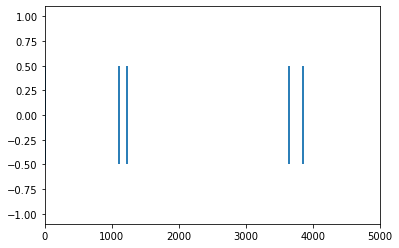

In [44]:
spk_rec_2 = spk_rec2
spk_rec_2 = torch.stack(spk_rec_2, dim=0)
spk_rec_2 = torch.flatten(spk_rec_2)
plot_single_train(spk_rec_2, nb_steps, timestep_size)

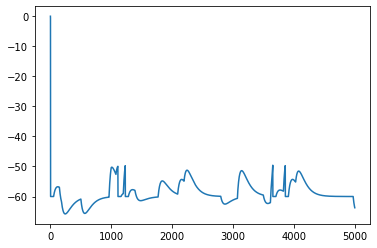

In [45]:
plt.plot(mem_rec_2)

In [53]:
print(spk_rec_1)

[tensor([1., 1., 1., 1.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0., 0., 0., 0.]), tensor([0.,

In [54]:
spk_rec_1_stack = torch.stack(spk_rec_1, dim=1)
print(spk_rec_1_stack.shape)

torch.Size([4, 5000])


mem-rec-1 shape: torch.Size([4, 5000])


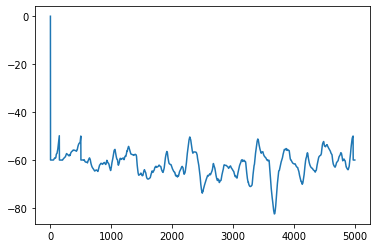

In [50]:
#mem_rec_1 = torch.stack(mem_rec_1, dim=1)
print("mem-rec-1 shape:", mem_rec_1.shape)
plt.plot(mem_rec_1[0])

In [26]:
epochs = 5

for i in tqdm(range(epochs)):
  spk_rec2, spk_rec_1

100%|██████████| 5/5 [00:00<00:00, 43329.59it/s]
